<a href="https://colab.research.google.com/github/azizboufaied/Interview_Task_1_Chicago_Crimes/blob/main/Graduate_assistant_task_for_Dr_Li.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neighborhood geometry types:
0     MultiPolygon
1     MultiPolygon
2     MultiPolygon
3     MultiPolygon
4     MultiPolygon
          ...     
93    MultiPolygon
94    MultiPolygon
95    MultiPolygon
96    MultiPolygon
97    MultiPolygon
Length: 98, dtype: object
Neighborhood CRS: EPSG:4326

Sample of crimes with neighborhood assignment:
         ID  Longitude   Latitude  neighborhood_id          PRI_NEIGH  \
0  13693249 -87.667099  41.903751             83.0          West Town   
1  13693379 -87.688086  41.917243             14.0       Logan Square   
2  13206696 -87.685595  41.901220             90.0  Ukrainian Village   
3  13323462 -87.701230  41.925283             14.0       Logan Square   
4  13206682 -87.692055  41.907578             89.0        Wicker Park   

                            SEC_NEIGH  
0               WICKER PARK,WEST TOWN  
1                        LOGAN SQUARE  
2  UKRAINIAN VILLAGE AND EAST VILLAGE  
3                        LOGAN SQUARE  
4               WICKE

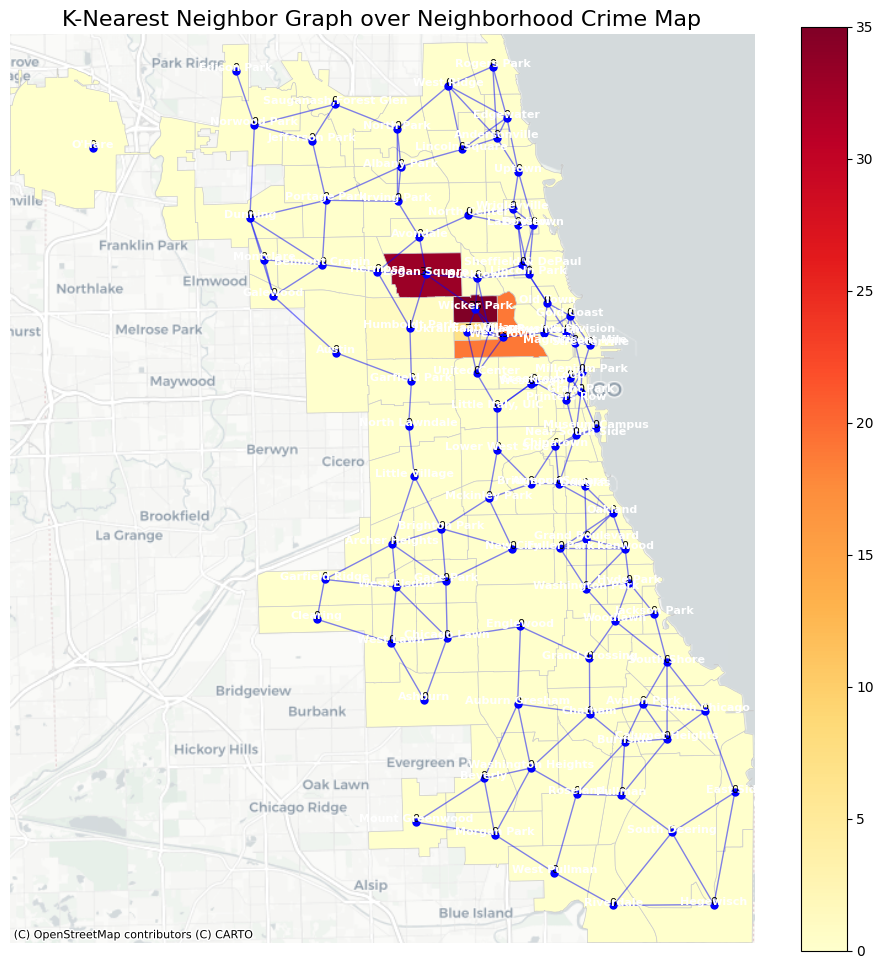

In [24]:
# -------------------------------
# STEP 0. IMPORT THE LIBRARIES WE NEED
# -------------------------------
# We’re bringing in the tools we’ll use throughout this script – for handling maps, data, geometry, etc.

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.neighbors import NearestNeighbors
import contextily as ctx
from shapely.geometry import Point

# -------------------------------
# STEP 1. LOAD OUR DATA & GET NEIGHBORHOOD IDs
# -------------------------------

# First, load the crime data from an Excel file (you can change the filename or path if needed)
crime_df = pd.read_excel("export (2).xlsx")
# Then, load the neighborhood data from a CSV file.
# This file should include a column called “the_geom” that stores the neighborhood shapes in WKT format (basically, a way to describe geometry using text)

neighborhood_df = pd.read_csv("Neighborhoods_2012b_20250406.csv")


# Let’s convert that 'the_geom' column into real geometric shapes Python can understand
neighborhood_df['geometry'] = gpd.GeoSeries.from_wkt(neighborhood_df['the_geom'])

# Now, we wrap that data into a GeoDataFrame and set the coordinate system to standard GPS coordinates (EPSG:4326)
neighborhoods = gpd.GeoDataFrame(neighborhood_df, geometry='geometry', crs="EPSG:4326")
# (Optional but useful!) Let's quickly check the type of shapes we’re working with and confirm the coordinate system
print("Neighborhood geometry types:")
print(neighborhoods.geometry.type)
print("Neighborhood CRS:", neighborhoods.crs)


# To make things easier later, we’ll assign a unique ID to each neighborhood – just numbering them from top to bottom
neighborhoods['neighborhood_id'] = neighborhoods.reset_index().index + 1

# Time to do the same for the crime data – turn it into a GeoDataFrame using the "Longitude" and "Latitude" columns
# This lets us treat the crime locations as points on the map
crimes = gpd.GeoDataFrame(crime_df,
                          geometry=gpd.points_from_xy(crime_df.Longitude, crime_df.Latitude),
                          crs="EPSG:4326")

# Perform a spatial join to identify the neighborhood each crime belongs to.

# We use the 'neighborhood_id', 'PRI_NEIGH', and 'SEC_NEIGH' fields from the neighborhood data to match crimes with their respective locations.
crimes_with_neighborhood = gpd.sjoin(crimes, neighborhoods[['neighborhood_id', 'PRI_NEIGH', 'SEC_NEIGH', 'geometry']],
                                     how='left', predicate='within')

# To ensure everything is clear, we’ll display a sample of the result with the key fields for easy inspection.
print("\nSample of crimes with neighborhood assignment:")
print(crimes_with_neighborhood[['ID', 'Longitude', 'Latitude', 'neighborhood_id', 'PRI_NEIGH', 'SEC_NEIGH']].head())

# For any missing neighborhood information, we'll fill in the gaps with 'Unknown' to maintain consistency.
crimes_with_neighborhood['PRI_NEIGH'] = crimes_with_neighborhood['PRI_NEIGH'].fillna('Unknown')


# -------------------------------
# STEP 2. CREATE CHOROPLETH MAP (Visualization Task)
# -------------------------------

# Begin with calculating the crime count for each  neighborhood this involves grouping the crime data by neighborhood and tallying the occurrences in each area.


crime_counts = crimes_with_neighborhood.groupby('neighborhood_id').size().reset_index(name='crime_count')

# Merge the crime counts back into the neighborhood GeoDataFrame so each neighborhood knows its crime tally.
neighborhoods = neighborhoods.merge(crime_counts, on='neighborhood_id', how='left')

# In case any neighborhoods have no recorded crimes, we’ll fill in a crime count of 0, ensuring a complete dataset.
neighborhoods['crime_count'] = neighborhoods['crime_count'].fillna(0)

# -------------------------------
# STEP 3. BUILD K-NEAREST NEIGHBORS GRAPH (Graph Task)
# -------------------------------
# To perform accurate distance calculations, we'll project the data into a Cartesian coordinate system (EPSG:3857).

neighborhoods_proj = neighborhoods.to_crs(epsg=3857)

# Compute the centroids of the neighborhoods using the projected geometries. These centroids represent the "center" of each neighborhood.
neighborhoods_proj['centroid'] = neighborhoods_proj['geometry'].centroid

# Extract the centroids into an array of X, Y coordinates to work with the distances
centroid_coords = np.array([[geom.x, geom.y] for geom in neighborhoods_proj['centroid']])


# Use K-Nearest Neighbors (KNN) to find the 5 closest neighborhoods to each centroid. (I request 6 because each neighborhood is always closest to itself.)

nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(centroid_coords)
distances, indices = nbrs.kneighbors(centroid_coords)

# Establish the K-Nearest Neighbors graph by adding an edge between neighborhoods that are mutual neighbors.G = nx.Graph()
for i, neighbors in enumerate(indices):
    for j in neighbors[1:]:  # skip the first neighbor (the point itself)
        if i in indices[j][1:]:
            G.add_edge(i, j)

# -----------------------------
# STEP 4. CREATE THE FINAL VISUALIZATION (Combine Tasks 2 and 3)
# -------------------------------

fig, ax = plt.subplots(figsize=(12, 12))

# Plot the neighborhoods, color-coded by crime count, to create a clear choropleth map.
neighborhoods_proj.plot(column='crime_count',
                        cmap='YlOrRd',
                        linewidth=0.5,
                        edgecolor='0.8',
                        ax=ax,
                        legend=True)

# Optionally, we can add crime count labels at the centroid of each neighborhood for further clarity.
for idx, row in neighborhoods_proj.iterrows():
    cx, cy = row['centroid'].x, row['centroid'].y
    ax.text(cx, cy, str(int(row['crime_count'])), fontsize=8, ha='center', color='black')

# Represent the centroids as blue circles on the map to highlight the central locations.
for point in neighborhoods_proj['centroid']:
    ax.plot(point.x, point.y, 'bo', markersize=5)

# Visualize the edges of the K-Nearest Neighbors graph, which represents the relationships between neighborhoods.
for i, j in G.edges():
    p1 = neighborhoods_proj.iloc[i].centroid
    p2 = neighborhoods_proj.iloc[j].centroid
    ax.plot([p1.x, p2.x], [p1.y, p2.y], color='blue', linewidth=1, alpha=0.5)

# Add a basemap using `contextily` for context and a clean backdrop.
try:
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
except Exception as e:
    print("Contextily could not add basemap. Error:", e)

# Optionally, include neighborhood labels (PRI_NEIGH) for better identification.
for idx, row in neighborhoods_proj.iterrows():
    cx, cy = row['centroid'].x, row['centroid'].y
    ax.text(cx, cy, str(row['PRI_NEIGH']), fontsize=8, ha='center', color='white', weight='bold')

# Zoom the plot to focus on the relevant area, ensuring the map displays only the neighborhoods of interest.
min_x, min_y, max_x, max_y = neighborhoods_proj.total_bounds
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

# Finalize the plot, adjusting any remaining details to enhance the clarity and presentation.
plt.title("K-Nearest Neighbor Graph over Neighborhood Crime Map", fontsize=16)
plt.axis('off')
plt.show()
